In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
# Using pip install to install those package


### Read Data

In [2]:
bank_rate = pd.read_csv('./Data/BoE-Database_export.csv')
fed_funds = pd.read_csv('./Data/FEDFUNDS.csv')
ftse100 = pd.read_csv('./Data/FTSE 100 Historical Price Data.csv')
sp500 = pd.read_csv('./Data/S&P 500 Historical Price Data.csv')
us_inflation = pd.read_csv('./Data/US Inflation RAte.csv')
uk_inflation = pd.read_csv('./Data/series-290524.csv')

In [3]:
bank_rate['Date'] = pd.to_datetime(bank_rate['Date'], format='%d-%m-%Y')
fed_funds['observation_date'] = pd.to_datetime(fed_funds['observation_date'])
ftse100['Date'] = pd.to_datetime(ftse100['Date'])
sp500['Date'] = pd.to_datetime(sp500['Date'])
us_inflation['Date'] = pd.to_datetime(us_inflation['Date'], format='%b-%y')
uk_inflation['Date'] = pd.to_datetime(uk_inflation['Date'], format='%b-%y')



/var/folders/tl/gr7ky_ln79195ycwht64zv_r0000gn/T/ipykernel_72125/1995424870.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ftse100['Date'] = pd.to_datetime(ftse100['Date'])
/var/folders/tl/gr7ky_ln79195ycwht64zv_r0000gn/T/ipykernel_72125/1995424870.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sp500['Date'] = pd.to_datetime(sp500['Date'])


# US

### Merge Data

In [4]:
# Convert all to monthly data if necessary, using the average or last value
sp500 = sp500.set_index('Date').resample('M').last()
fed_funds = fed_funds.set_index('observation_date').resample('M').last()
us_inflation = us_inflation.set_index('Date').resample('M').last()

# Merge datasets on the date index
df = pd.concat([sp500[['Price']], fed_funds['FEDFUNDS'], us_inflation['Inflation Rates']], axis=1)
df.columns = ['SP500_Price', 'FEDFUNDS', 'US_Inflation']


### Data Cleaning

In [5]:
# Conver data from Object type to float type
df['SP500_Price'] = df['SP500_Price'].replace('[\$,]', '', regex=True)
df['SP500_Price'] = pd.to_numeric(df['SP500_Price'], errors='coerce')
df.dropna(inplace=True)



In [6]:
from sklearn.preprocessing import MinMaxScaler

# Nomarlise the data
scaler = MinMaxScaler()
df['FEDFUNDS'] = scaler.fit_transform(df[['FEDFUNDS']])
df['SP500_Price'] = scaler.fit_transform(df[['SP500_Price']])
df['US_Inflation'] = scaler.fit_transform(df[['US_Inflation']])


### Regression Analysis

#### Laggin Effect

In [7]:
# Creating lagged variables
df['FEDFUNDS_lag1'] = df['FEDFUNDS'].shift(-1)  # 1-month lag
df['FEDFUNDS_lag3'] = df['FEDFUNDS'].shift(-3)  # 3-months lag
df['FEDFUNDS_lag6'] = df['FEDFUNDS'].shift(-6)  # 6-months lag

df['US_Inflation_lag1'] = df['US_Inflation'].shift(-1)  # 1-month lag
df['US_Inflation_lag3'] = df['US_Inflation'].shift(-3)  # 3-months lag
df['US_Inflation_lag6'] = df['US_Inflation'].shift(-6)  # 6-months lag


#### Regression

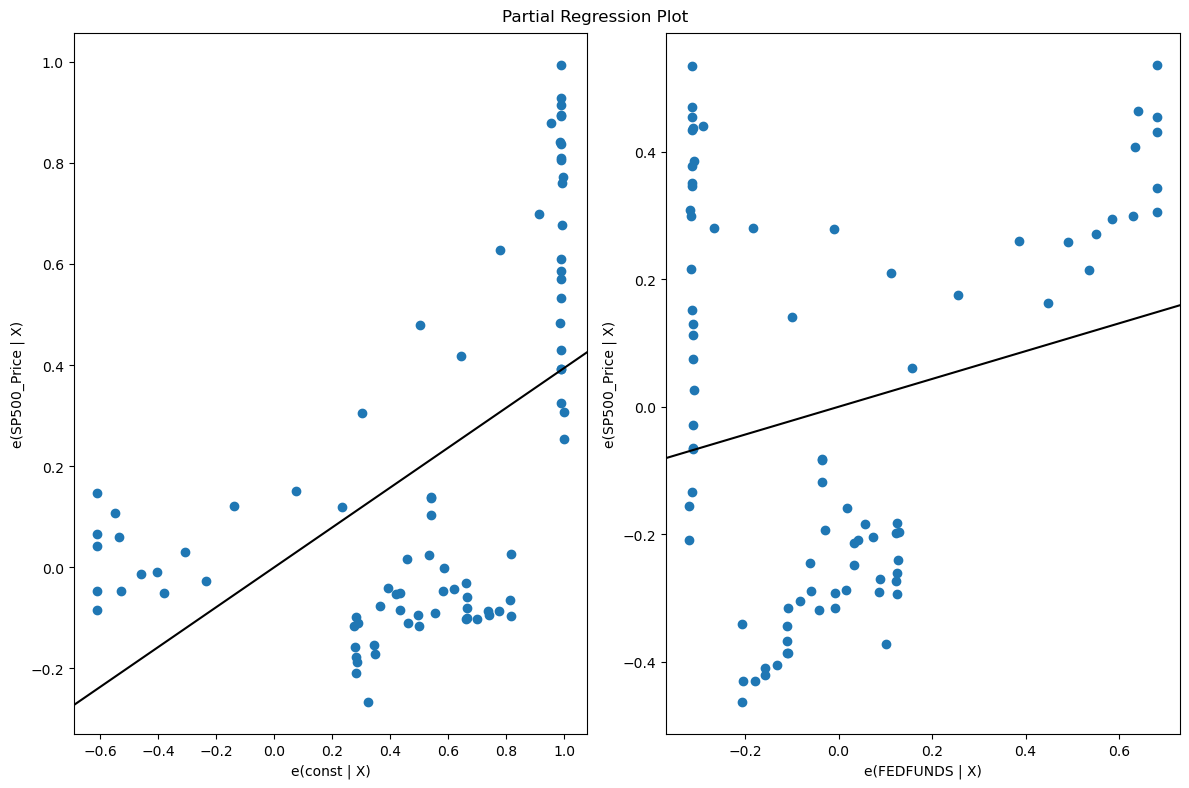

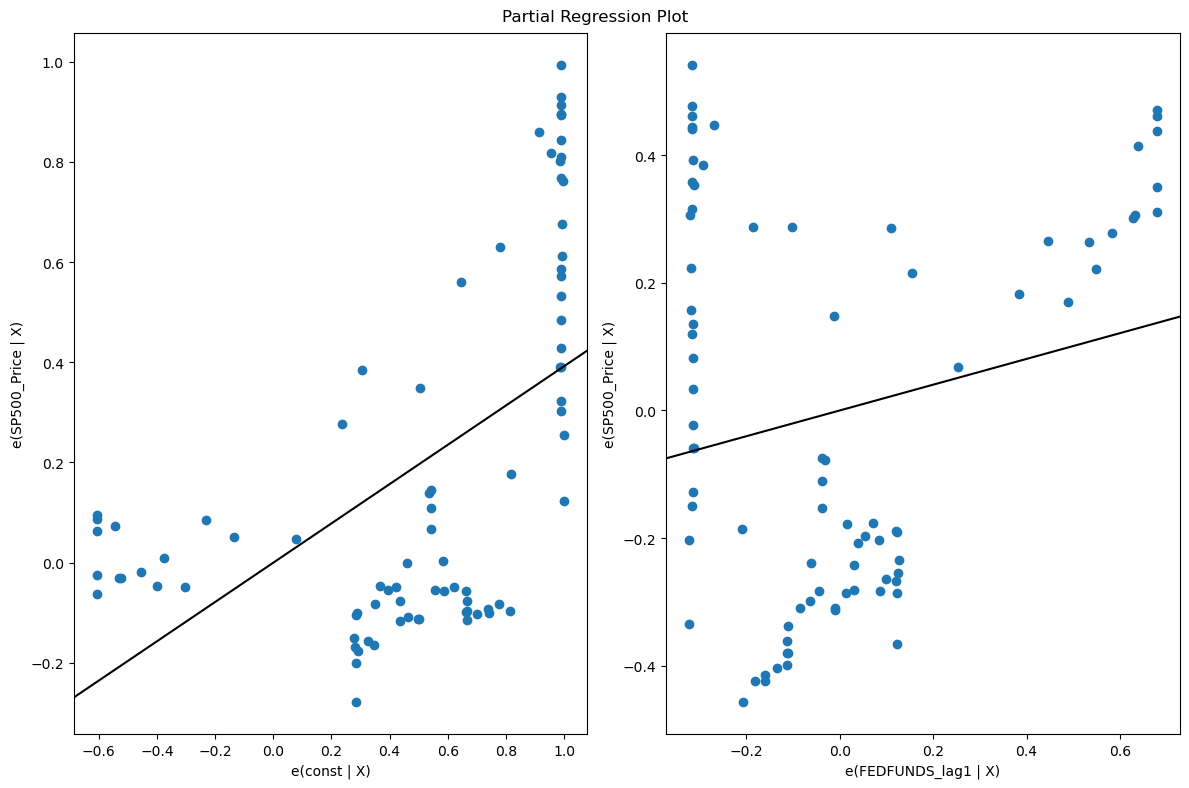

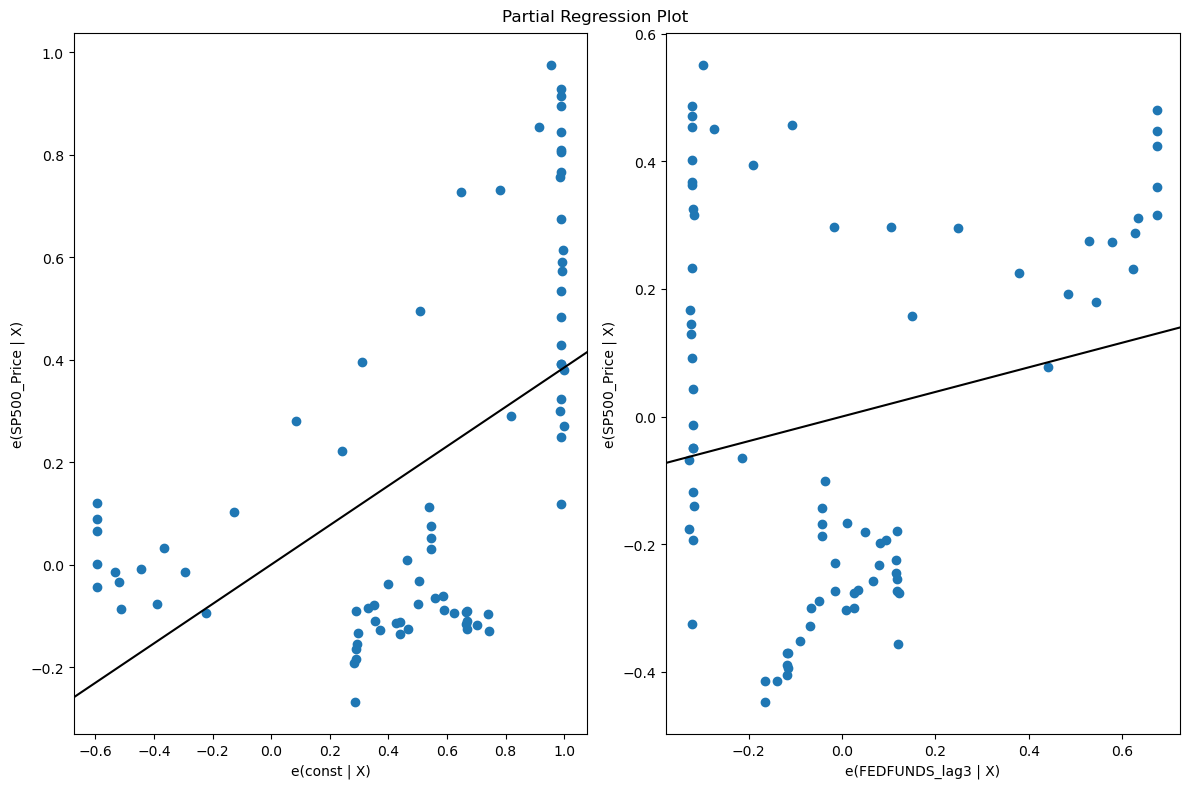

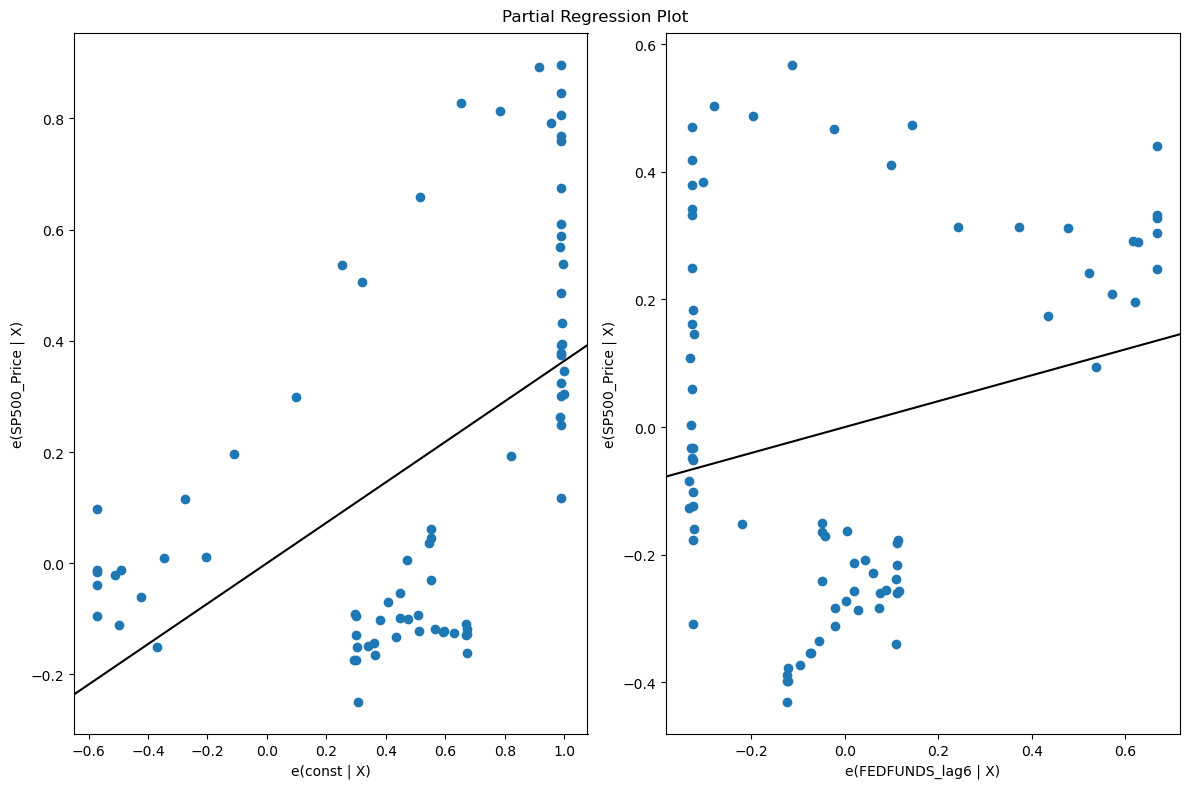

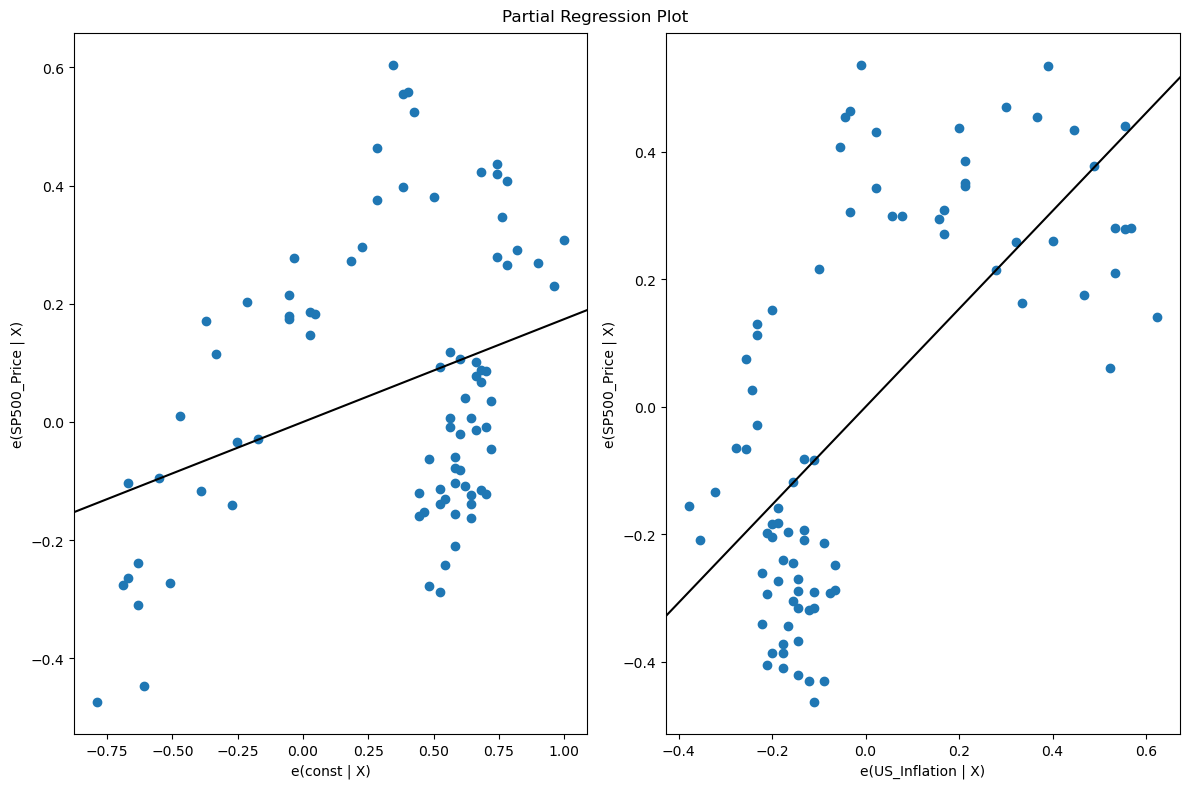

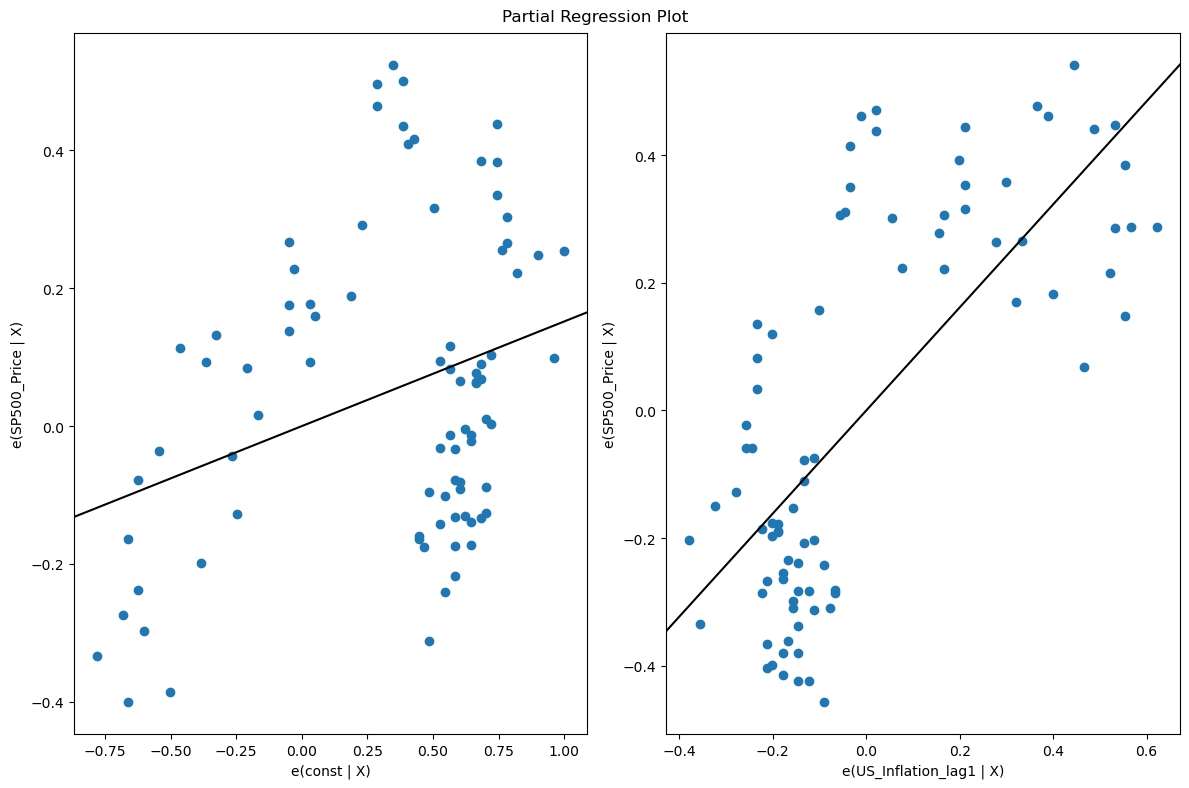

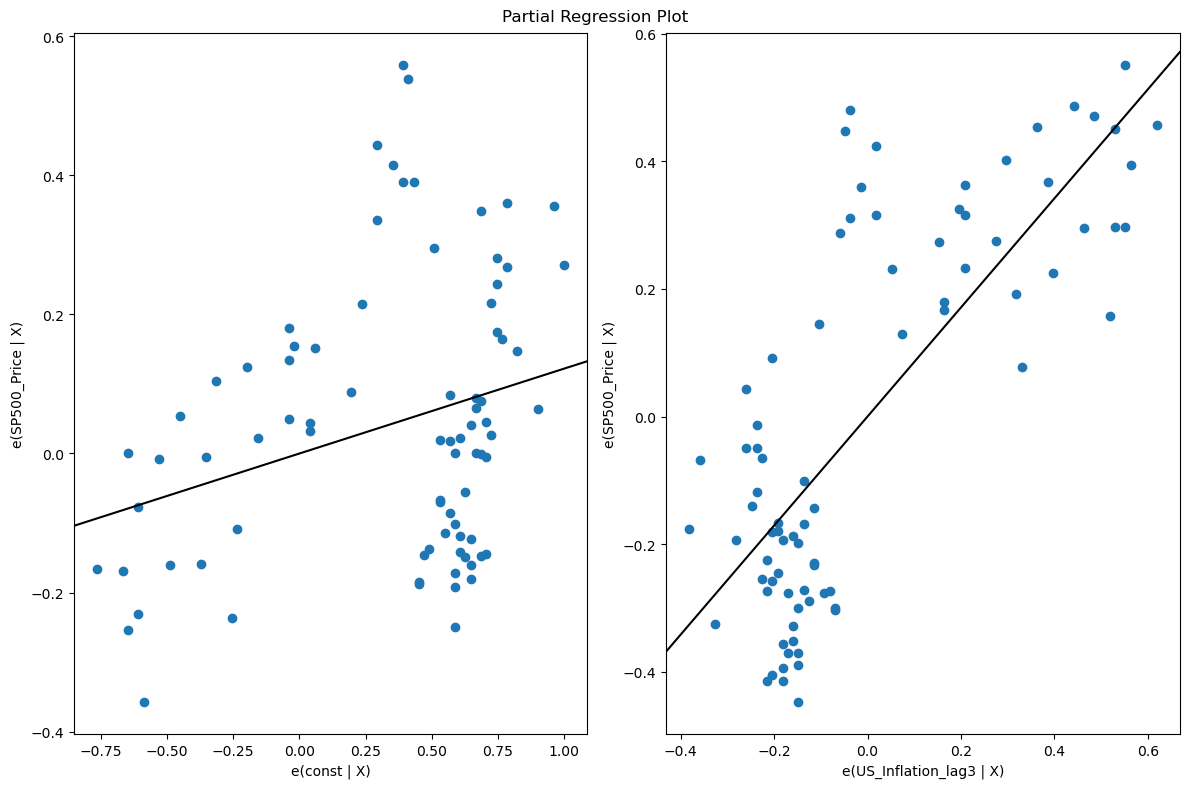

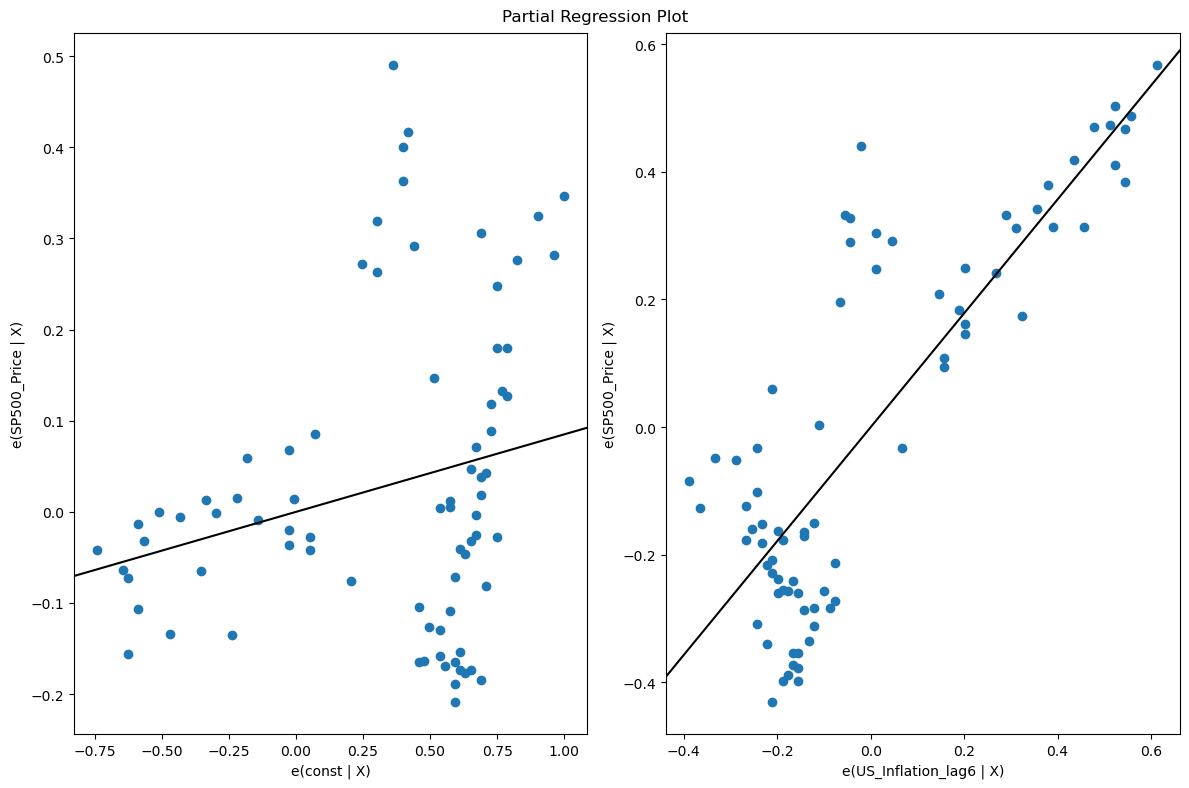

In [8]:
for x in ['FEDFUNDS', 'FEDFUNDS_lag1', 'FEDFUNDS_lag3', 'FEDFUNDS_lag6', 'US_Inflation', 'US_Inflation_lag1', 'US_Inflation_lag3', 'US_Inflation_lag6']:
    X = df[[x]]
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    y = df['SP500_Price']
    
    X.dropna(inplace=True)
    y = y.loc[X.index]
    
    model = sm.OLS(y, X).fit()
    
    # Plot partial regression plots
    fig = plt.figure(figsize=(12, 8))
    fig = sm.graphics.plot_partregress_grid(model, fig=fig)
    
    fig.savefig('./fig/graph_' + x + '.png')
    
    with open('./Results/regression_summary_' + x + '.txt', 'w') as file:
        file.write(model.summary().as_text())

# UK

### Merge Data

In [9]:
# Convert all to monthly data if necessary, using the average or last value
ftse100 = ftse100.set_index('Date').resample('M').last()
bank_rate = bank_rate.set_index('Date').resample('M').last()
uk_inflation = uk_inflation.set_index('Date').resample('M').last()

# Merge datasets on the date index
df = pd.concat([ftse100[['Price']], bank_rate['Bank Rate'], uk_inflation['Inflation']], axis=1)
df.columns = ['FTSE100_Price', 'Interest_Rate', 'UK_Inflation']

### Data Cleaning

In [10]:
# Conver data from Object type to float type
df['FTSE100_Price'] = df['FTSE100_Price'].replace('[\$,]', '', regex=True)
df['FTSE100_Price'] = pd.to_numeric(df['FTSE100_Price'], errors='coerce')
df.dropna(inplace=True)


In [11]:
from sklearn.preprocessing import MinMaxScaler
# Normalise the data
scaler = MinMaxScaler()
df['Interest_Rate'] = scaler.fit_transform(df[['Interest_Rate']])
df['FTSE100_Price'] = scaler.fit_transform(df[['FTSE100_Price']])
df['UK_Inflation'] = scaler.fit_transform(df[['UK_Inflation']])

### Regression Analysis

#### Lagging Effect

In [12]:
# Creating lagged variables
df['Interest_Rate_lag1'] = df['Interest_Rate'].shift(-1)  # 1-month lag
df['Interest_Rate_lag3'] = df['Interest_Rate'].shift(-3)  # 3-months lag
df['Interest_Rate_lag6'] = df['Interest_Rate'].shift(-6)  # 6-months lag

df['UK_Inflation_lag1'] = df['UK_Inflation'].shift(-1)  # 1-month lag
df['UK_Inflation_lag3'] = df['UK_Inflation'].shift(-3)  # 3-months lag
df['UK_Inflation_lag6'] = df['UK_Inflation'].shift(-6)  # 6-months lag


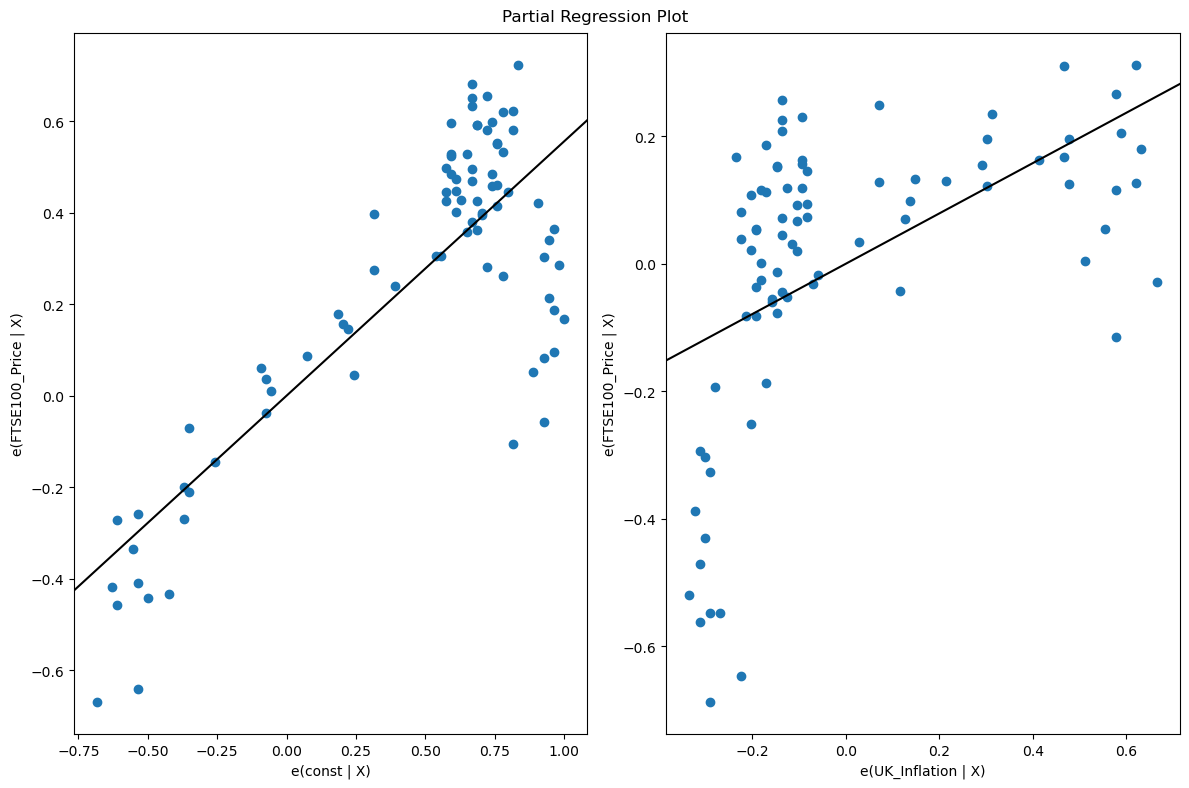

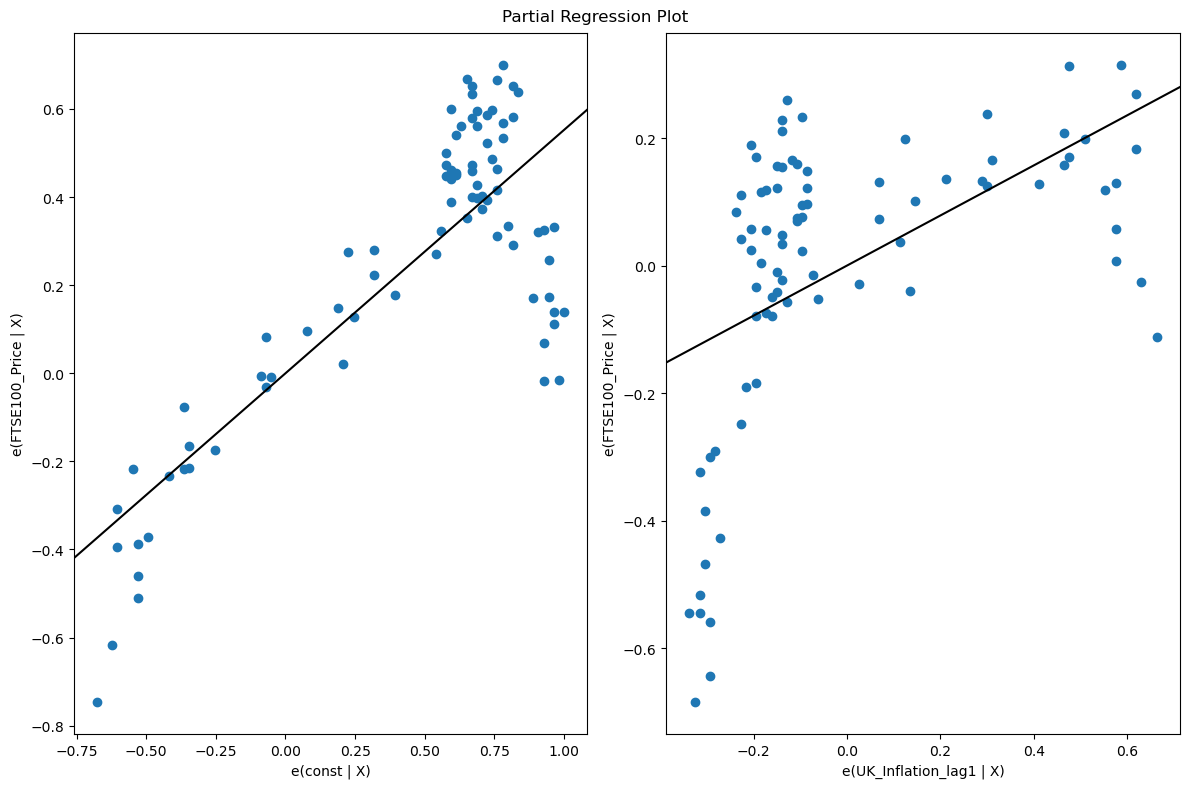

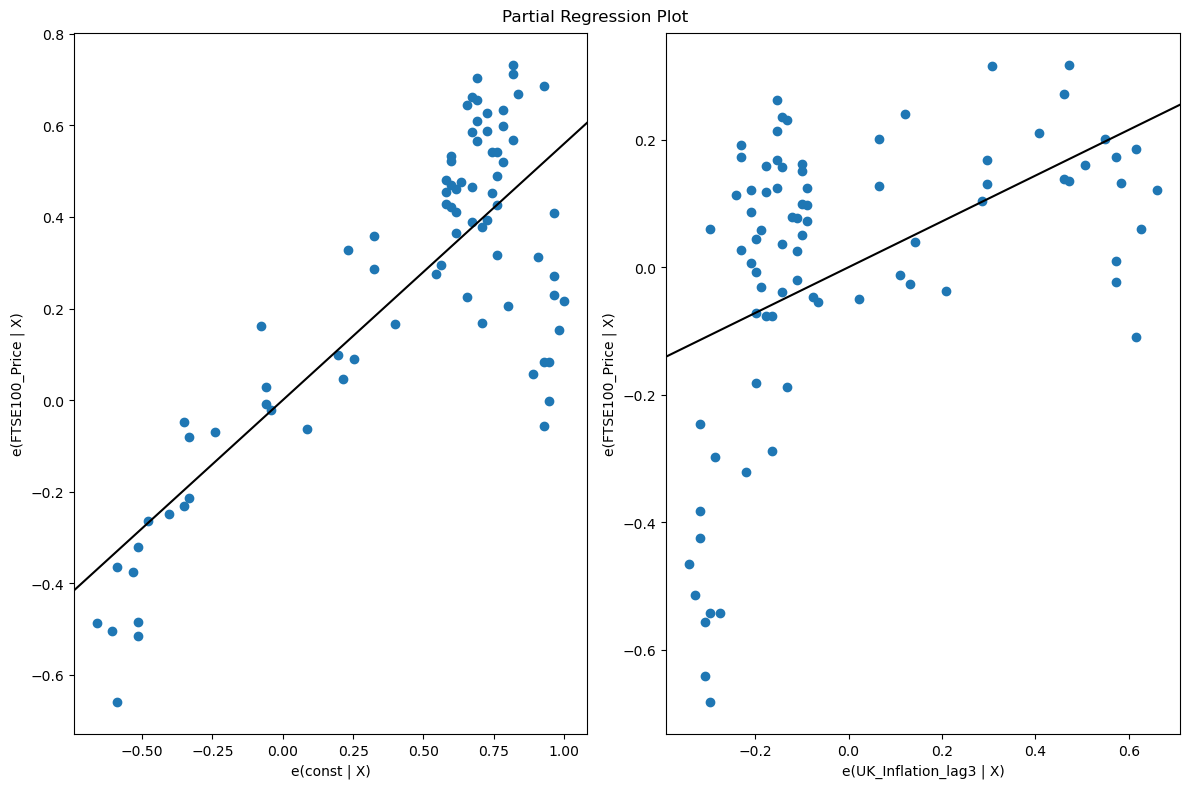

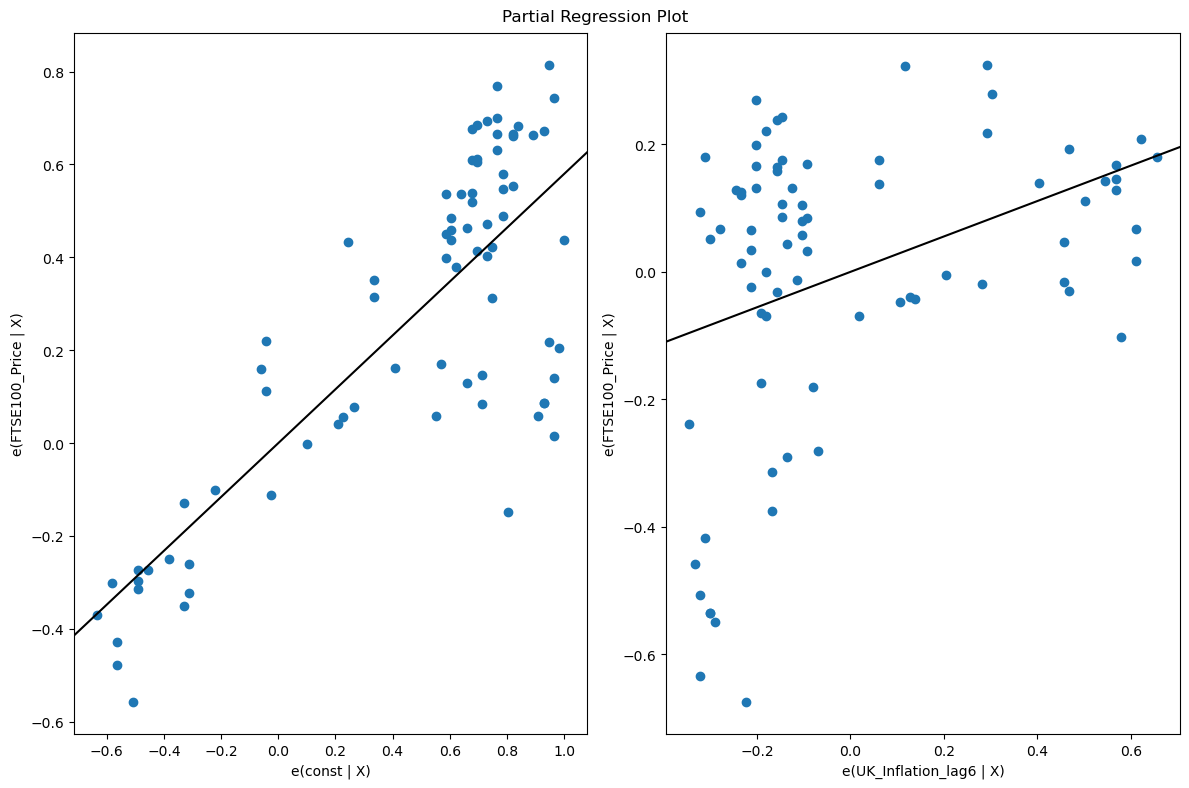

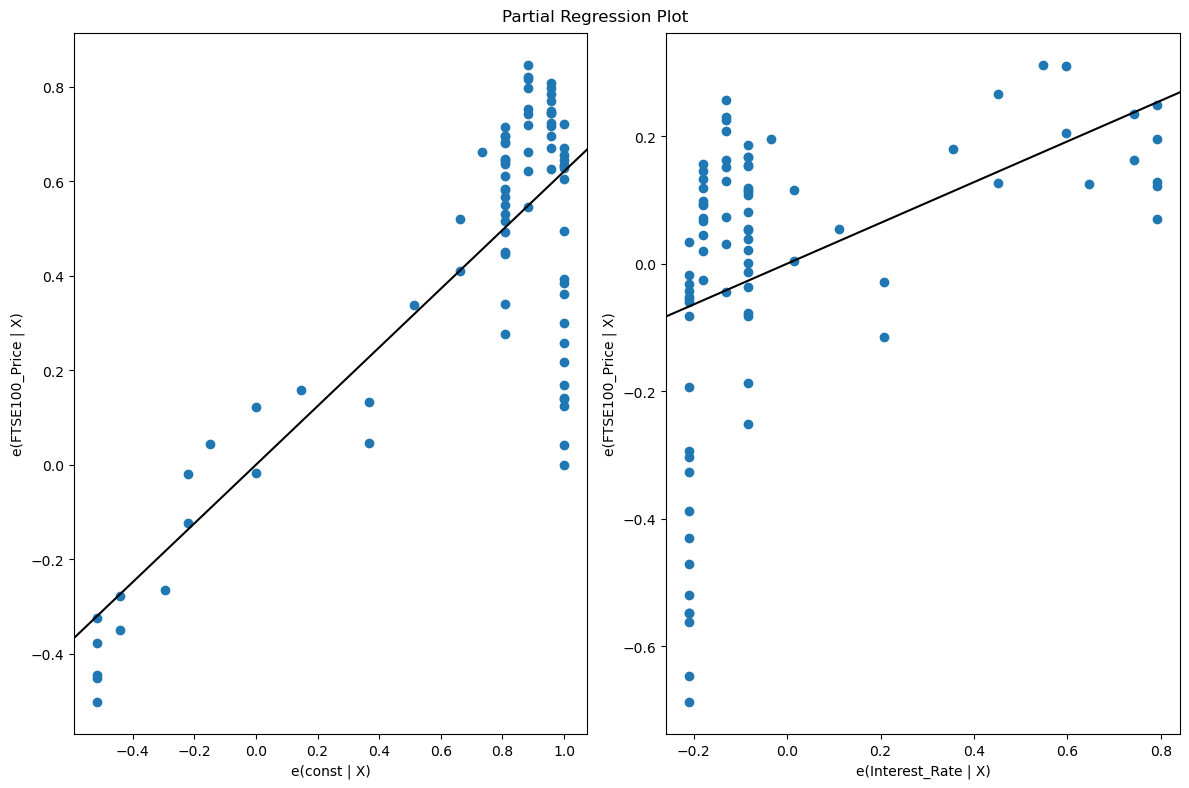

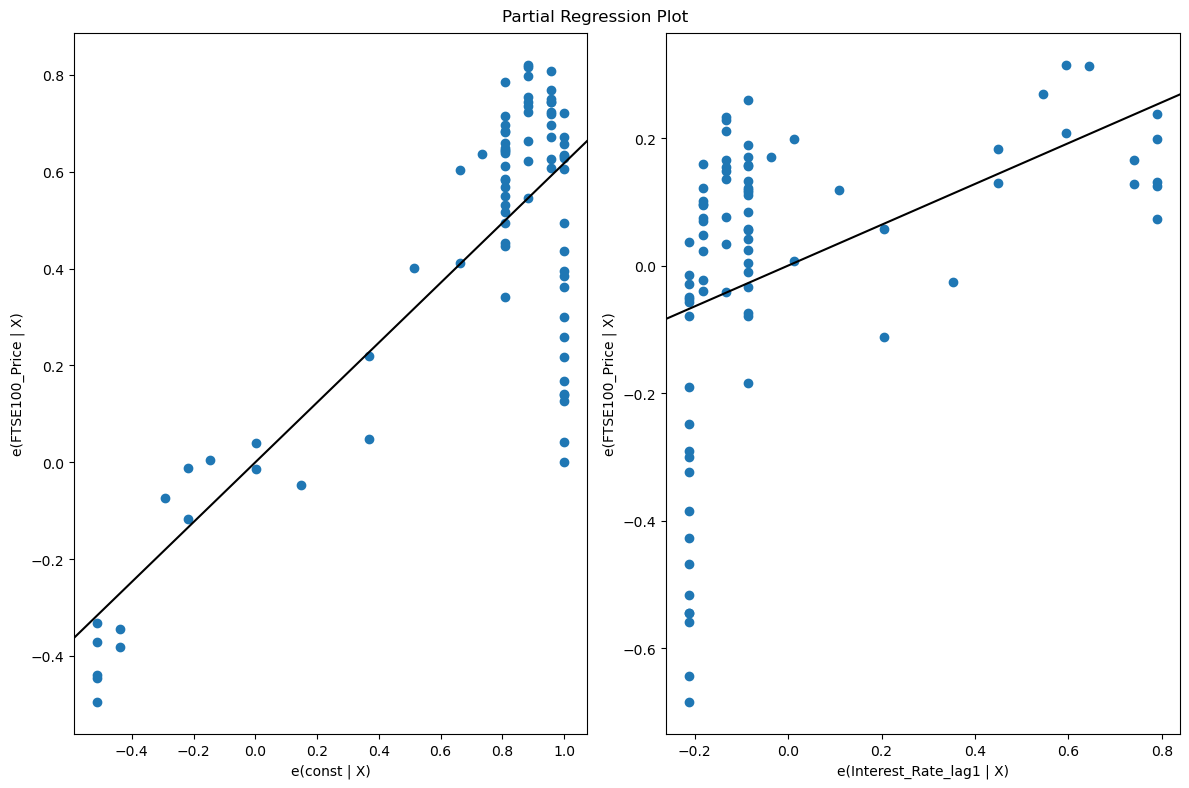

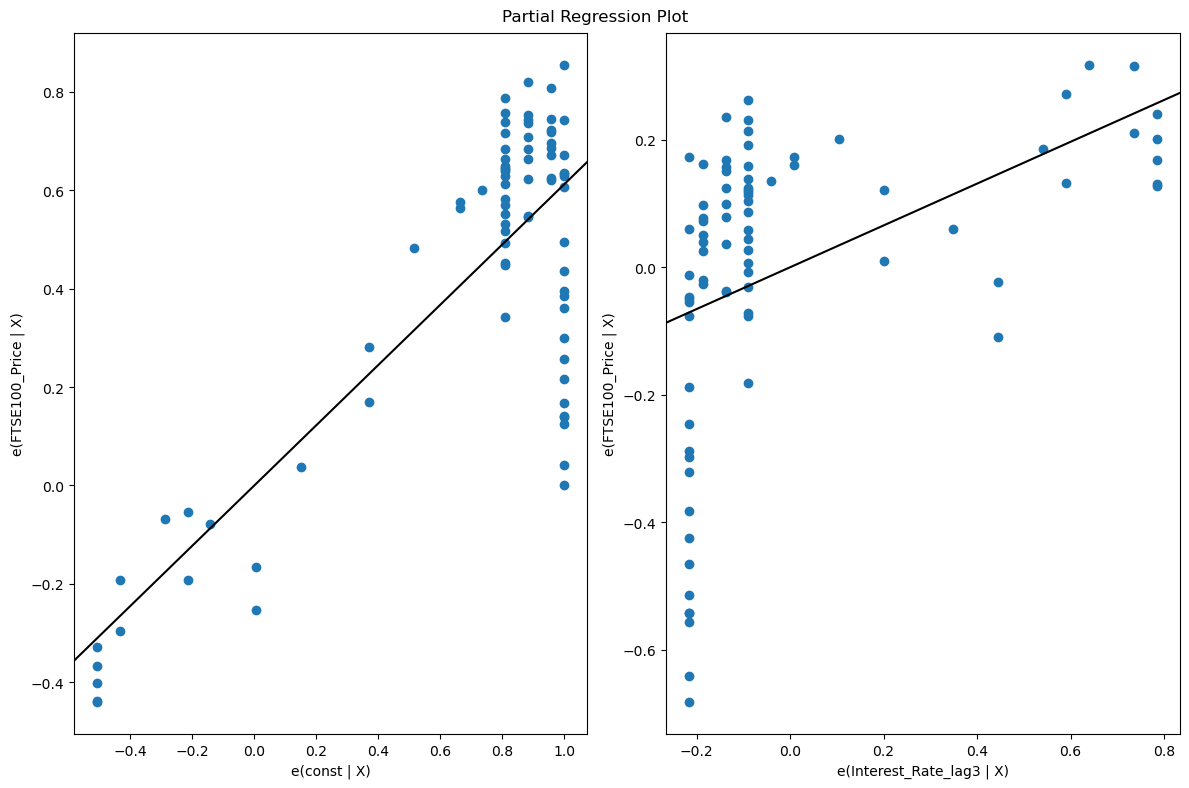

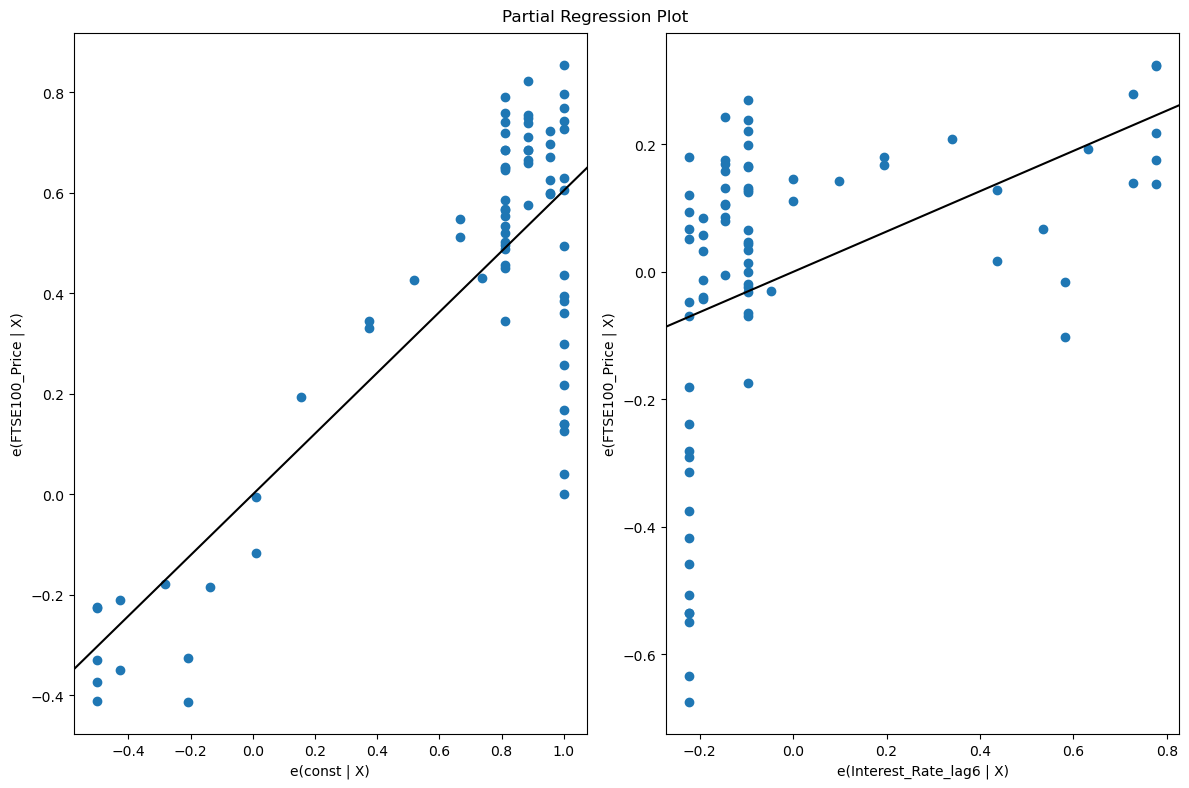

In [13]:
for x in ['UK_Inflation', 'UK_Inflation_lag1', 'UK_Inflation_lag3', 'UK_Inflation_lag6', 'Interest_Rate', 'Interest_Rate_lag1', 'Interest_Rate_lag3', 'Interest_Rate_lag6']:
    X = df[[x]]
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    y = df['FTSE100_Price']
    
    X.dropna(inplace=True)
    y = y.loc[X.index]
    
    model = sm.OLS(y, X).fit()
    
    # Plot partial regression plots
    fig = plt.figure(figsize=(12, 8))
    fig = sm.graphics.plot_partregress_grid(model, fig=fig)
    
    
    fig.savefig('./fig/graph_' + x + '.png')
    
    with open('./Results/regression_summary_' + x + '.txt', 'w') as file:
        file.write(model.summary().as_text())